# Kaggle: House Prices: Advanced Regression Techniques

In this notebook, I will be finding ways to predict home prices using primarily regression techniques. After self-learning Data Analysis and Python for around a year, I decided to enter my first Kaggle competition to further my knowledge. I also decided to complete this notebook on my own without using any publicly available kernels so that I can learn as much as possible. 

Overall, I found switching from learning mode to actually trying to compete with others was difficult, but I found that I have learnt a huge amount from this notebook, including the use of "boosting" models that take "weak learners" into "strong learners". I also find myself forgetting a few crucial points when analyzing data, such as remember to ensure that many models only work well with normally distributed data. In the future however, I do not think I will forget those points, especially after this notebook.

To start this notebook, I first import the necessary libraries below and read the train and test data. I will make a copy of both data in case I need to reference the original

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold


train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
train_data = train.copy()
test_data = test.copy()

%matplotlib inline  

## Correlation

In [ ]:
train.head()

In [ ]:
fig, ax = plt.subplots(figsize=(30,10)) 
sns.heatmap(train.corr(), ax=ax, annot=True)

We can see above that features such as OverallQual, GRrLiv, GarageCars and GarageArea. However it is also worth noting that features such as GarageCars and GarageArea are highly correlated to each other. Id should be removed as it does not help in any way here. Very low correlated features such as YrSold and MiscVal should be considered for removal as well as it is possible that the small amount of correlation we are seeing are just random effects.

## Missing Data

In [ ]:
fig, ax = plt.subplots(figsize=(15,4)) 
plt.xticks(rotation="vertical")
plt.bar(train_data.columns,train_data.isnull().sum()/len(train_data))
plt.title("Missing Data")

We can see that some features in this dataset is missing alot of data. Features such as PoolQC and MiscFeature is missing more than 90% values. In this case, it probably makes sense to drop these columns, especially as we have seen in our correlation analysis, that some features including MiscFeature are also not very correlated with SalePrice (response column) at all.  

## Handling Missing Data and Imputation

I first decided to drop columns that are either missing much values or those that are unlikely to have any predictive power.

In [ ]:
train_data = train_data.drop(["PoolQC", "Id", "Alley","Fence", "MiscFeature", "FireplaceQu"], axis=1)
test_data = test_data.drop(["PoolQC", "Id","Alley","Fence", "MiscFeature", "FireplaceQu"], axis=1)

Missing data that involves Garage or Basement likely just means that the home in question do not have a garage or basement. In those cases, its better to either fill the missing values with 0 (in case of numeric data) or put "None" (in case of categorical data). 

In [ ]:
train_data[["GarageCars", "GarageArea", "GarageYrBlt"]] = train_data[["GarageCars", "GarageArea", "GarageYrBlt"]].fillna(0)
test_data[["GarageCars", "GarageArea", "GarageYrBlt"]] = test_data[["GarageCars", "GarageArea", "GarageYrBlt"]].fillna(0)
train_data["GarageYrBlt"] = train_data["GarageYrBlt"].astype(int)
test_data["GarageYrBlt"] = test_data["GarageYrBlt"].astype(int)

In [ ]:
test_data[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageCars"]] = test_data[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageCars"]].fillna(0)

In [ ]:
lr_train_cols_impute = train_data.loc[:,train_data.isnull().any()].select_dtypes("number")
lr_test_cols_impute = test_data.loc[:,test_data.isnull().any()].select_dtypes("number")

The Remaning two numeric columns with missing data, "LotFrontage" and "MasVnrArea" is filled with Linear Regression Imputation. I thought this might be a better approach than mean imputation since LotFrontage is missing almost around 20% of data.

In [ ]:
def imputeLR(column, data):
    needLRImpute = data.loc[:,data.isnull().any()].select_dtypes("number")
    LRImputeMissingRows = needLRImpute[needLRImpute.isnull().any(axis=1)]
    LRcompleteRows = needLRImpute[~needLRImpute.isnull().any(axis=1)]
    
    train = data.copy()
    target = data[column]
    train = data.select_dtypes("number").drop(needLRImpute.columns, axis=1)
    
    imputeLr = LinearRegression()
    imputeLr.fit(train.iloc[LRcompleteRows.index],target.iloc[LRcompleteRows.index])
    LRImputeMissingRow = LRImputeMissingRows[LRImputeMissingRows[column].isnull()]
    
    return pd.Series(imputeLr.predict(train.iloc[LRImputeMissingRows.index]), index=LRImputeMissingRows.index, dtype='float64')
    

In [ ]:
for item in lr_train_cols_impute.columns:
    train_data[item] = train_data[item].fillna(imputeLR(item, train_data))
for item in lr_test_cols_impute.columns:
    test_data[item] = test_data[item].fillna(imputeLR(item, test_data))
    

In [ ]:
train_data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = train_data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]].fillna("None")
test_data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = test_data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]].fillna("None")

In [ ]:
train_labelKNNImpute = train_data.loc[:,train_data.isnull().any()]
test_labelKNNImpute = test_data.loc[:,test_data.isnull().any()]

I then used KNN imputation to fill in missing categorical data for the train and test data set

In [13]:
def knnImpute(col, data):
    copyData = data.copy()
    labelKNNImpute = data.loc[:,data.isnull().any()]
    
    copyData = copyData.drop(labelKNNImpute.columns, axis=1)
    
    labelCols = copyData.select_dtypes("object")
    copyData = pd.concat([copyData, pd.get_dummies(labelCols)], axis=1)
    copyData = copyData.drop(labelCols, axis=1)
    KNN = KNeighborsClassifier(5, weights='distance')
    
    currentTarget = labelKNNImpute[col]
    currentMissing = labelKNNImpute[labelKNNImpute[col].isnull()]
    
    indexOfComplete = labelKNNImpute[labelKNNImpute[col].notnull()].index
    
    currentTrain = copyData.iloc[indexOfComplete]
    currentTarget = currentTarget.iloc[indexOfComplete]
    fit = KNN.fit(currentTrain, currentTarget)
    
    return pd.Series(fit.predict(copyData.iloc[currentMissing.index]), index=currentMissing.index)

In [14]:
for item in train_labelKNNImpute.columns:
    train_data[item] = train_data[item].fillna(knnImpute(item, train_data))
    
for item in test_labelKNNImpute.columns:
    test_data[item] = test_data[item].fillna(knnImpute(item, test_data))

## Outliers

I am mostly interested in whether there are outliers in the response data. To test this, I plot a scatter plot of the living area vs sale price. I believe it it reasonable to assume that a larger home will fetch a higher price, therefore using living area is a good way to find outliers.

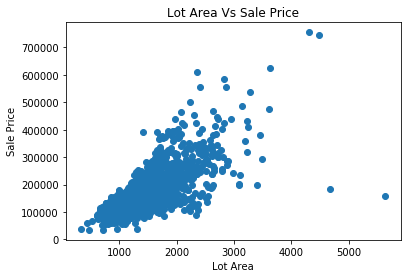

In [15]:
plt.xlabel("Lot Area")
plt.ylabel("Sale Price")
plt.title("Lot Area Vs Sale Price")
plt.scatter(train_data["GrLivArea"],train_data["SalePrice"])


We can see in the above graph that there definitely seems to be a few outliers. In order to remove them, I found the z-score for the SalePrice column, and then remove any values that are more than 3 standard deviations away. 

In [16]:
zscores_train = train_data.select_dtypes("number").apply(lambda x: abs(stats.zscore(x)))

In [18]:
train_data = train_data.drop(zscores_train[zscores_train["SalePrice"] > 3].index).reset_index(drop=True)

### Transformation

Below, I decided to change all categorical data into a numeric format to allow the models to use those data. Furthermore, some of the model I will using works better when the response column follows a normal distribution

In [27]:
non_numeric = train_data.select_dtypes("object")

In [28]:
full_train = train_data.copy()
full_train[non_numeric.columns] = full_train[non_numeric.columns].astype("category")
full_train[non_numeric.columns] = full_train[non_numeric.columns].apply(lambda x: x.cat.codes)

In [29]:
full_test = test_data.copy()
full_test[non_numeric.columns] = full_test[non_numeric.columns].astype("category")
full_test[non_numeric.columns] = full_test[non_numeric.columns].apply(lambda x: x.cat.codes)

In [31]:
current_x = full_train.copy()
current_y = current_x["SalePrice"]
current_x = current_x.drop("SalePrice", axis=1)

As we can see below, the response column is slightly skewed. To make it more normal, I decided to apply the log function to the response data

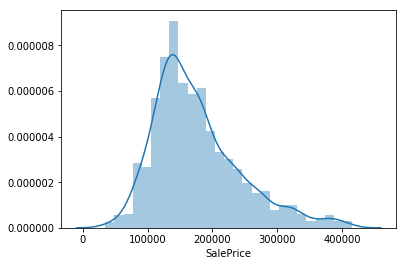

In [38]:
sns.distplot(current_y)

In [40]:
current_y = np.log(current_y)

## Models

### Lasso Regression

In [84]:
lasso = LassoCV(cv=5)
lasso.fit(current_x, current_y)
lasso.score(current_x, current_y)

0.7526522113970943

### Random Forest

In [89]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(current_x, current_y)
rf.score(current_x, current_y)

0.981257190269236

### Xtreme Gradient Boosting

In [99]:
xgb = XGBRegressor(colsample_bytree= 0.3, learning_rate=0.15, n_estimators=100, reg_alpha=0.2)

In [100]:
xgb.fit(current_x, current_y)
xgb.score(current_x, current_y)

0.9494930341459166

In [101]:
predictions = xgb.predict(full_test)

In [102]:
predictions = np.exp(predictions)

### Submission Codes

In [103]:
currentSubmit = test_data.copy()
currentSubmit["SalePrice"] = predictions
currentSubmit["Id"] = test["Id"]

In [104]:
currentSubmit[["Id","SalePrice"]].to_csv("submission.csv", index=False)

### Reference

In [ ]:
lr_data = train_data.copy()
drop_non_numeric = lr_data.select_dtypes("object")
lr_data = pd.concat([lr_data, pd.get_dummies(drop_non_numeric)], axis=1)
lr_data = lr_data.drop(drop_non_numeric, axis=1)

In [ ]:
current_x["GrLivArea"] = np.log(current_x["GrLivArea"])
current_x['TotalBsmtSF'] = np.log(current_x['TotalBsmtSF'])
full_test["GrLivArea"] = np.log(full_test["GrLivArea"])
full_test['TotalBsmtSF'] = np.log(full_test['TotalBsmtSF'])

In [1]:
result = 0
for x in range(101):
    if x % 6 == 0:
        result += x
print(result)

816
